# Lecture 8

## Esercizio 08.2

Adoperiamo un codice Variational Monte Carlo per una particella quantistica monodimensionale in moto nel potenziale $$
V(x) = x^4 - \frac{5}{2}x^2
$$
servendoci dell'algoritmo di Metropolis per campionare una funzione d'onda di prova $|\Psi_T(x)|^2$, dove una buona Trial Function è data da 
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$.

Consideriamo una probabilità di transizione uniforme $T(x|y)$: $x = unif(y - \delta, y+\delta)$, dove $\delta$ è il parametro da modificare per regolare l'Acceptance Rate a circa $0.5$. Al fine di trovare la funzione d'onda del Ground State, calcoliamo il valore di aspettazione dell'Hamiltoniana 

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

e minimizziamo tale quantità, in modo tale da ottenere i migliori parametri $\mu$ (distanza dall'origine media) e $\sigma$ (radice quadrata della larghezza delle due gaussiane) per il GS:
$$
\langle {\hat H} \rangle_T = \frac{\langle \Psi_T^{\sigma,\mu}| {\hat H} | \Psi_T^{\sigma,\mu} \rangle}
{\langle \Psi_T^{\sigma,\mu} | \Psi_T^{\sigma,\mu} \rangle} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

Per trovare i migliori parametri, calcoliamo il valore dell'energia al variare di $\mu$ e $\sigma$ e definiamo "parametri ottimizzati" quelli per cui si ha l'energia minima (corrispondente alla migliore approssimazione del Ground State), facendo attenzione ad impostare una $\delta$ tale da avere un Acceptance Rate di circa $0.5$. Esaminando i valori ottenuti variando i parametri, a partire da grandi intervalli fino a restringere sempre di più la zona di interesse, otteniamo: 
- $\delta$ = 2.65;
- $\mu$ = 0.808;
- $\sigma$ = 0.618

A seguire la soluzione numerica ottenuta trasformando l'equazione di Schrödinger in un'equazione matriciale:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
mu=0.808
sigma=0.618

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 6
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

Confrontiamo ora la soluzione numerica con i risultati ottentui dal VMC con i valori dei parametri ottimizzati, utilizzando $N=100$ blocchi per un totale di $M=10^6$ tentativi.
Grafichiamo quindi $\langle {H} \rangle_T$ in funzione del numero di step MC:

Ground State energy:  -0.4604584507991174
VMC Ground State energy:  -0.444466


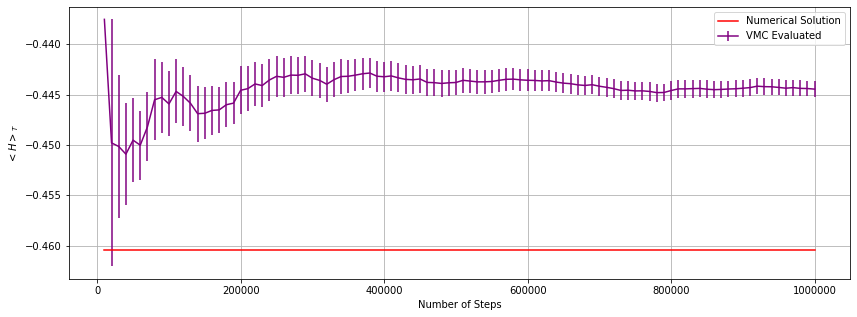

In [3]:
block,H,H_err=np.loadtxt("ES8.2/Energy.dat", usecols=(0,1,2), delimiter=" ", unpack='true')
print("Ground State energy: ", E[0])
print("VMC Ground State energy: ", H[-1]) 

target=np.zeros(len(block))
for i in range(len(block)):
    target[i]=E[0]
plt.figure(0,figsize=(14,5))
plt.errorbar(block,H,yerr=H_err,label='VMC Evaluated', color='purple')
plt.plot(block,target,label='Numerical Solution', color='red')
plt.legend(loc='upper right')
plt.xlabel("Number of Steps")
plt.ylabel(r"$<H>_T$")
plt.grid(True)
plt.show()

Dal grafico vediamo che il valore di aspettazione dell'energia per la funzione di prova non risulta compatibile con l'autovalore del GS ottenuto dalla discretizzazione dell'equazione di Schrödinger. Ottimizzando la Trial Function si può quindi approssimare il GS del sistema, ma rimangono delle discrepanze legate alla funzione di prova stessa considerata.

Confrontiamo ora le probabilità $p^{\mu,\sigma}(x) = |{\psi}_{T}^{\mu,\sigma}(x)|^2$ ottenute dal campionamento VMC con la soluzione analitica della funzione d'onda (valutata con i parametri ottimizzati) e con la soluzione numerica derivante dalla discretizzazione dell'equazione di Schrödinger:

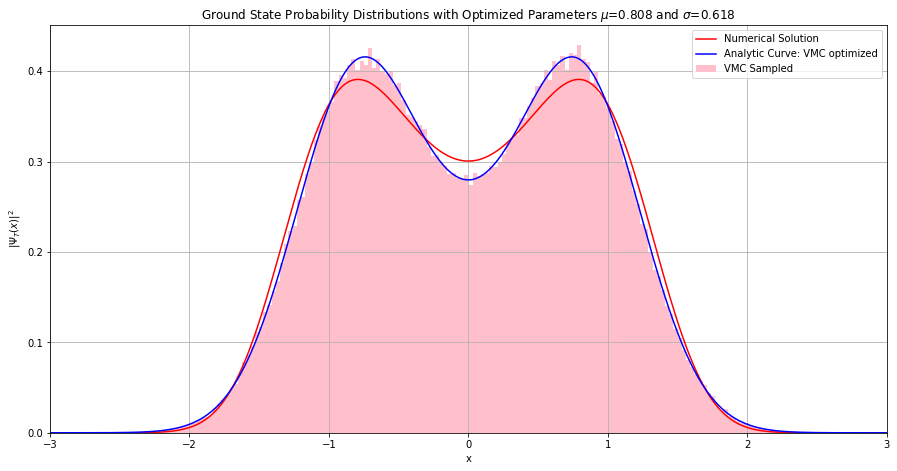

In [38]:
def psiT(x):                              
    t1=((x-mu)/sigma)**2
    t2=((x+mu)/sigma)**2
    return np.exp(-t1/2)+np.exp(-t2/2)

psiVMC=np.loadtxt("ES8.2/Points.dat", usecols=(0), unpack='true')

plt.figure(0,figsize=(15,7.5))
bins=200
psi_opt=(psiT(x))**2     #analytical curve
N=np.sum(dx*psi_opt)

plt.plot(x,(psi[0])**2, label='Numerical Solution', color='red')
plt.hist(psiVMC,bins,range=(-3,3),label='VMC Sampled',density='true',color='pink')
plt.plot(x,psi_opt/N, label='Analytic Curve: VMC optimized', color='blue')

plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel("$|\Psi_T(x)|^2$")
plt.title(f"Ground State Probability Distributions with Optimized Parameters $\mu$={mu} and $\sigma$={sigma}")
plt.xlim((-3,3))
plt.grid(True)
plt.show()

Anche dalle distribuzioni di probabilità possiamo notare la discrepanza tra la soluzione numerica data dalla discretizzazione dell'equazione di Schrödinger e il metodo VMC adottato, seppure risulti evidente la somiglianza nella forma delle curve.

## Esercizio 08.3

Sfruttiamo ora il metodo PIGS (Path Integral Ground State) per $T=0$ (tempo immaginario $it=8$, $300$ timescales) nel caso di
- funzione di prova COSTANTE, $\Psi_T(x)=1$
- funzione di prova OTTIMIZZATA $\Psi_T(x) = \Psi_T^{\sigma,\mu}(x)$ 

e confrontiamo i risultati con quelli precedentemente ottenuti con VMC.
Per quanto riguarda la distribuzioni di probabilità:

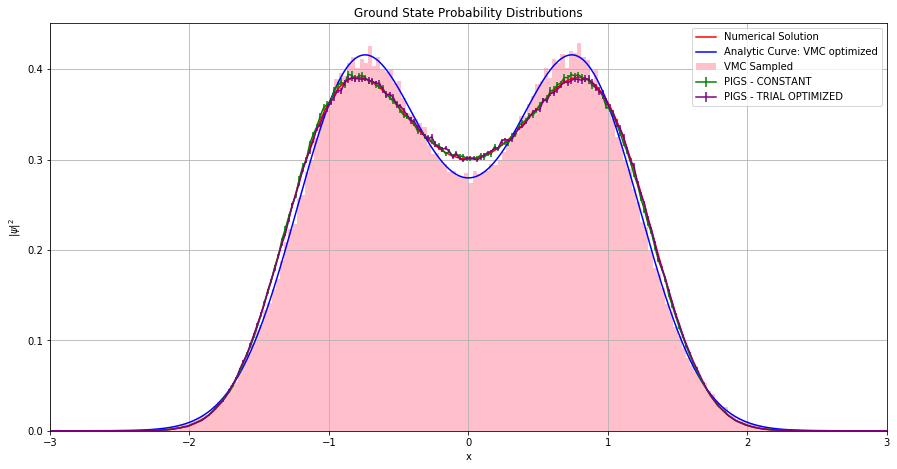

In [40]:
def psiT(x):
    t1=((x-mu)/sigma)**2
    t2=((x+mu)/sigma)**2
    return np.exp(-t1/2)+np.exp(-t2/2)

psiVMC=np.loadtxt("ES8.2/Points.dat", usecols=(0), unpack='true')
x_const,psi_const,err_const=np.loadtxt("ES8.3/CONST_probability_it=8.dat", usecols=(0,1,2), unpack='true')
x_trial,psi_trial,err_trial=np.loadtxt("ES8.3/TRIAL_probability_it=8.dat", usecols=(0,1,2), unpack='true')
plt.figure(0,figsize=(15,7.5))
bins=200
psi_opt=(psiT(x))**2
N=np.sum(dx*psi_opt)

plt.plot(x,(psi[0])**2, label='Numerical Solution', color='red')
plt.hist(psiVMC,bins,range=(-3,3),label='VMC Sampled',density='true',color='pink')
plt.plot(x,psi_opt/N, label='Analytic Curve: VMC optimized', color='blue')
plt.errorbar(x_const,psi_const,yerr=err_const,label='PIGS - CONSTANT', color='green')
plt.errorbar(x_trial,psi_trial,yerr=err_trial,label='PIGS - TRIAL OPTIMIZED', color='purple')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel(r"$|\psi|^2$")
plt.title(f"Ground State Probability Distributions")
plt.xlim((-3,3))
plt.grid(True)
plt.show()

Come vediamo, le curve ottenute dal metodo PIGS risultano invece in accordo con la soluzione numerica prima trovata dalla discretizzazione dell'equazione di Schrödinger.
Ciò accade perchè tale metodo è esatto: gli errori di approssimazione possono essere ridotti fino a trovarsi al di sotto della soglia dell'incertezza statistica. Pertanto il limite del PIGS è legato a fattori pratici (per esempio al tempo di calcolo a disposizione), diversamente dal caso variazionale del VMC, dove invece il limite consiste proprio nella scelta della funzione d'onda di prova che, pur ottimizzata al meglio, risulta solo un'approssimazione del GS.

Plottiamo ora i valori di energia cinetica, potenziale e totale ottenuti con il metodo PIGS a T=0 (tempo immaginario $it=8$, $300$ timeslices) nel caso di funzione di prova costante e usando invece quella ottimizzata riportata sopra, a confronto con la soluzione numerica:

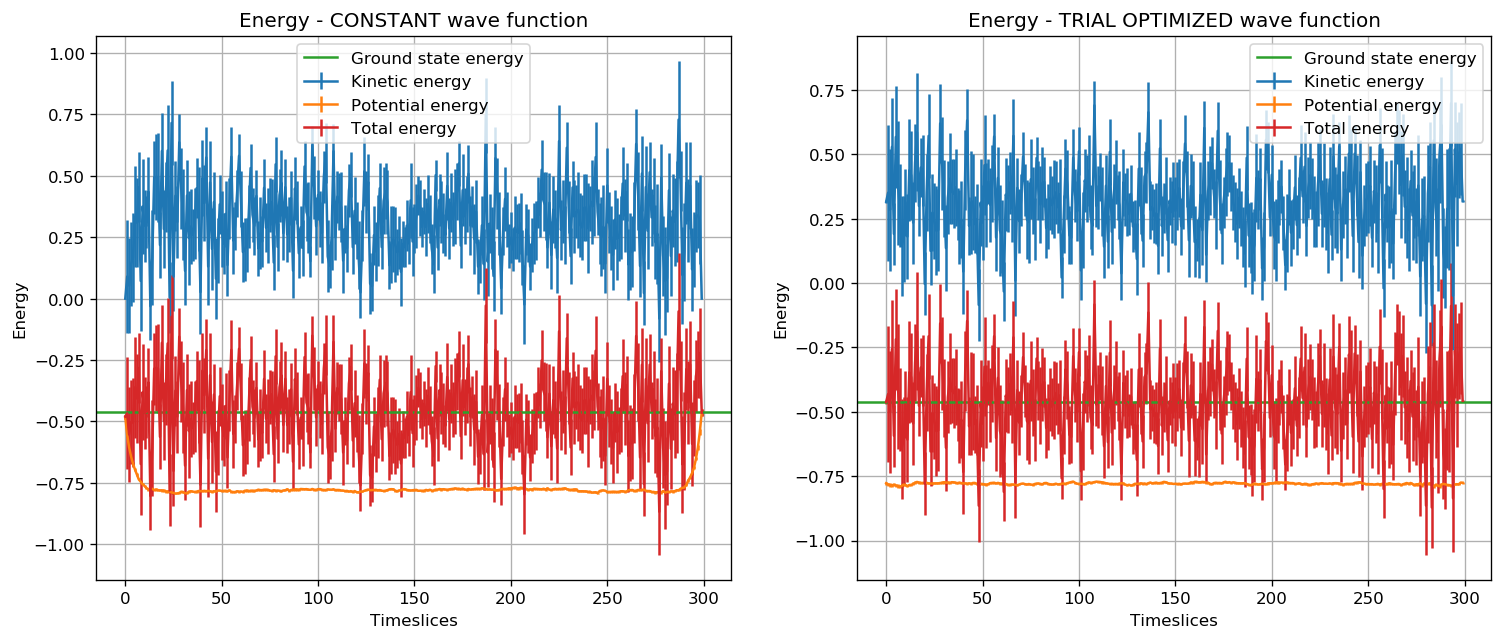

In [41]:
timeslices,ekin_const,ekin_err_const=np.loadtxt("ES8.3/CONST_kinetic_it=8.dat", delimiter=" ", usecols=(0,1,2), dtype="int,float,float", unpack=True)
timeslices,epot_const,epot_err_const=np.loadtxt("ES8.3/CONST_potential_it=8.dat", delimiter=" ", usecols=(0,1,2), dtype="int,float,float", unpack=True)
timeslices,ekin_opt,ekin_err_opt=np.loadtxt("ES8.3/TRIAL_kinetic_it=8.dat", delimiter=" ", usecols=(0,1,2), dtype="int,float,float", unpack=True)
timeslices,epot_opt,epot_err_opt=np.loadtxt("ES8.3/TRIAL_potential_it=8.dat", delimiter=" ", usecols=(0,1,2), dtype="int,float,float", unpack=True)
etot_const = ekin_const + epot_const
etot_err_const = np.sqrt(ekin_err_const**2+epot_err_const**2)
etot_opt = ekin_opt + epot_opt
etot_err_opt = np.sqrt(ekin_err_opt**2+epot_err_opt**2)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,6), dpi=120)

ax1.set_title("Energy - CONSTANT wave function")
ax1.errorbar(timeslices,ekin_const,yerr=ekin_err_const, label="Kinetic energy")
ax1.errorbar(timeslices,epot_const,yerr=epot_err_const, label="Potential energy")
ax1.errorbar(timeslices,etot_const,yerr=etot_err_const, label="Total energy",color="C3")
ax1.axhline(E[0],0,1, label="Ground state energy",color="C2")
ax1.grid()
ax1.set_xlabel(r"Timeslices")
ax1.set_ylabel("Energy")
ax1.legend()

ax2.set_title("Energy - TRIAL OPTIMIZED wave function")
ax2.errorbar(timeslices,ekin_opt,yerr=ekin_err_opt, label="Kinetic energy")
ax2.errorbar(timeslices,epot_opt,yerr=epot_err_opt, label="Potential energy")
ax2.errorbar(timeslices,etot_opt,yerr=etot_err_opt, label="Total energy",color="C3")
ax2.axhline(E[0],0,1, label="Ground state energy",color="C2")
ax2.grid()
ax2.set_xlabel(r"Timeslices")
ax2.set_ylabel("Energy")
ax2.legend()

plt.show()

Di nuovo il metodo PIGS risulta più efficace: l'energia totale corrispondente al Ground State ottenuta dai calcoli risulta in perfetto accordo con quella attesa. Inoltre notiamo che, partendo dalla funzione d'onda variazionale ottimizzata, non si vede il transiente iniziale nell'energia potenziale e cinetica (che invece è visibile nella funzione di prova costante). Ciò accade perchè la funzione d'onda considerata è più simile al GS già in partenza: le varie proiezioni la perfezionano, ma non si nota un cambiamento brusco come per la funzione d'onda costante.

Procediamo ora variando invece il tempo immaginario, a partire da $it=8$ come nei calcoli precedenti, fino ad arrivare a valori molto piccoli, nel nostro caso $it=0.01$ e vediamo come varia il grafico della probabilità in ambedue i casi di funzione di prova costante o ottimizzata.
Ciò è utile per valutare per quanto tempo è necessario proiettare la funzione d'onda iniziale per ottenere una curva abbastanza assimilabile a quella del GS.

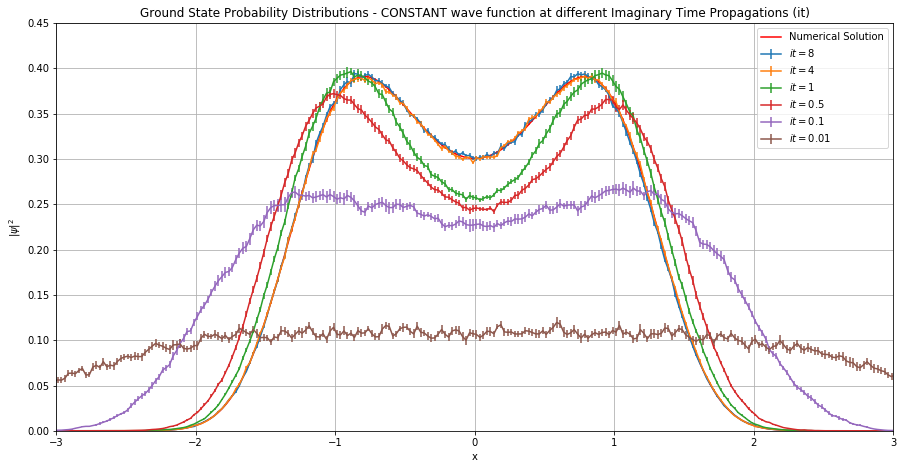

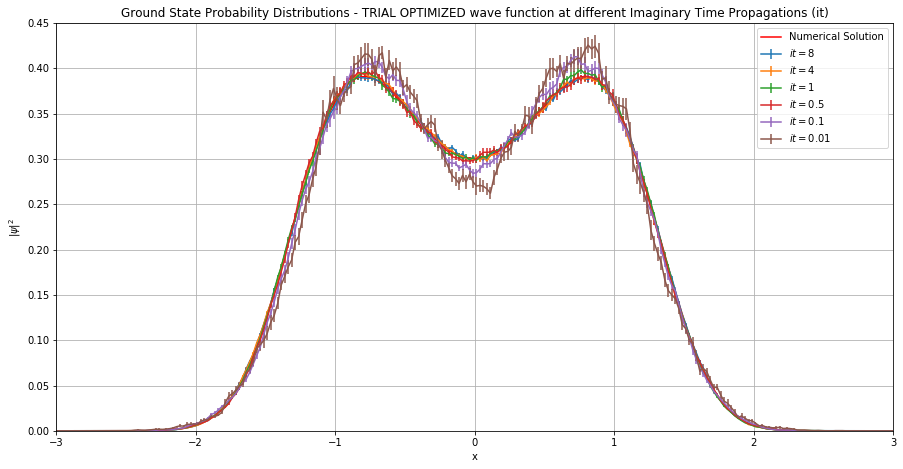

In [25]:
x_c8,psi_c8,err_c8=np.loadtxt("ES8.3/CONST_probability_it=8.dat", usecols=(0,1,2), unpack='true')
x_c4,psi_c4,err_c4=np.loadtxt("ES8.3/CONST_probability_it=4.dat", usecols=(0,1,2), unpack='true')
x_c1,psi_c1,err_c1=np.loadtxt("ES8.3/CONST_probability_it=1.dat", usecols=(0,1,2), unpack='true')
x_c05,psi_c05,err_c05=np.loadtxt("ES8.3/CONST_probability_it=0.5.dat", usecols=(0,1,2), unpack='true')
x_c01,psi_c01,err_c01=np.loadtxt("ES8.3/CONST_probability_it=0.1.dat", usecols=(0,1,2), unpack='true')
x_c001,psi_c001,err_c001=np.loadtxt("ES8.3/CONST_probability_it=0.01.dat", usecols=(0,1,2), unpack='true')
plt.figure(0,figsize=(15,7.5))

plt.errorbar(x_c8,psi_c8,yerr=err_c8,label='$it=8$')
plt.errorbar(x_c4,psi_c4,yerr=err_c4,label='$it=4$')
plt.errorbar(x_c1,psi_c1,yerr=err_c1,label='$it=1$')
plt.errorbar(x_c05,psi_c05,yerr=err_c05,label='$it=0.5$')
plt.errorbar(x_c01,psi_c01,yerr=err_c01,label='$it=0.1$')
plt.errorbar(x_c001,psi_c001,yerr=err_c001,label='$it=0.01$')
plt.plot(x,(psi[0])**2, label='Numerical Solution', color='red')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel(r"$|\psi|^2$")
plt.title(f"Ground State Probability Distributions - CONSTANT wave function at different Imaginary Time Propagations (it)")
plt.xlim((-3,3))
plt.ylim((0,0.45))
plt.grid(True)
plt.show()

x_t8,psi_t8,err_t8=np.loadtxt("ES8.3/TRIAL_probability_it=8.dat", usecols=(0,1,2), unpack='true')
x_t4,psi_t4,err_t4=np.loadtxt("ES8.3/TRIAL_probability_it=4.dat", usecols=(0,1,2), unpack='true')
x_t1,psi_t1,err_t1=np.loadtxt("ES8.3/TRIAL_probability_it=1.dat", usecols=(0,1,2), unpack='true')
x_t05,psi_t05,err_t05=np.loadtxt("ES8.3/TRIAL_probability_it=0.5.dat", usecols=(0,1,2), unpack='true')
x_t01,psi_t01,err_t01=np.loadtxt("ES8.3/TRIAL_probability_it=0.1.dat", usecols=(0,1,2), unpack='true')
x_t001,psi_t001,err_t001=np.loadtxt("ES8.3/TRIAL_probability_it=0.01.dat", usecols=(0,1,2), unpack='true')
plt.figure(0,figsize=(15,7.5))

plt.errorbar(x_t8,psi_t8,yerr=err_t8,label='$it=8$')
plt.errorbar(x_t4,psi_t4,yerr=err_t4,label='$it=4$')
plt.errorbar(x_t1,psi_t1,yerr=err_t1,label='$it=1$')
plt.errorbar(x_t05,psi_t05,yerr=err_t05,label='$it=0.5$')
plt.errorbar(x_t01,psi_t01,yerr=err_t01,label='$it=0.1$')
plt.errorbar(x_t001,psi_t001,yerr=err_t001,label='$it=0.01$')
plt.plot(x,(psi[0])**2, label='Numerical Solution', color='red')
plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel(r"$|\psi|^2$")
plt.title(f"Ground State Probability Distributions - TRIAL OPTIMIZED wave function at different Imaginary Time Propagations (it)")
plt.xlim((-3,3))
plt.ylim((0,0.45))
plt.grid(True)
plt.show()

Nel caso della funzione di prova COSTANTE (primo grafico) vediamo che per tempi piccoli la funzione d'onda proiettata resta piuttosto simile a quella iniziale costante mentre, aumentando il tempo di propagazione immaginario, si ottengono delle curve sempre più simili a quella attesa calcolata a partire dalla discretizzazione dell'equazione di Schrödinger (lo stato diventa essenzialmente proporzionale allo stato di GS).

Nel caso della funzione di prova OTTIMIZZATA (secondo grafico) lo stato iniziale è già molto simile al Ground State, dunque le curve risultano più compatibili anche a tempi immaginari ridotti.

Infine, ci proponiamo di utilizzare il metodo PIMC (Path Integral Monte Carlo) per vedere come cambia la distribuzione di probabilità al variare della temperatura.

Ho considerato temperature nel range $[0.5, 100]$.

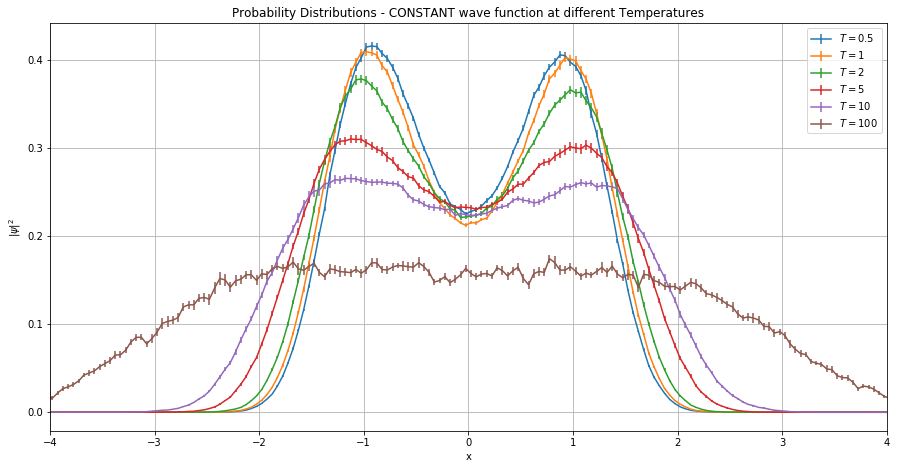

In [43]:
x_05,psi_05,err_05=np.loadtxt("ES8.3/CONST_probability_T=0.5.dat", usecols=(0,1,2), unpack='true')
x_1,psi_1,err_1=np.loadtxt("ES8.3/CONST_probability_T=1.dat", usecols=(0,1,2), unpack='true')
x_2,psi_2,err_2=np.loadtxt("ES8.3/CONST_probability_T=2.dat", usecols=(0,1,2), unpack='true')
x_5,psi_5,err_5=np.loadtxt("ES8.3/CONST_probability_T=5.dat", usecols=(0,1,2), unpack='true')
x_10,psi_10,err_10=np.loadtxt("ES8.3/CONST_probability_T=10.dat", usecols=(0,1,2), unpack='true')
x_100,psi_100,err_100=np.loadtxt("ES8.3/CONST_probability_T=100.dat", usecols=(0,1,2), unpack='true')
plt.figure(0,figsize=(15,7.5))

plt.errorbar(x_05,psi_05,yerr=err_05,label='$T=0.5$')
plt.errorbar(x_1,psi_1,yerr=err_1,label='$T=1$')
plt.errorbar(x_2,psi_2,yerr=err_2,label='$T=2$')
plt.errorbar(x_5,psi_5,yerr=err_5,label='$T=5$')
plt.errorbar(x_10,psi_10,yerr=err_10,label='$T=10$')
plt.errorbar(x_100,psi_100,yerr=err_100,label='$T=100$')

plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel(r"$|\psi|^2$")
plt.title("Probability Distributions - CONSTANT wave function at different Temperatures")
plt.xlim((-4,4))
plt.grid(True)
plt.show()

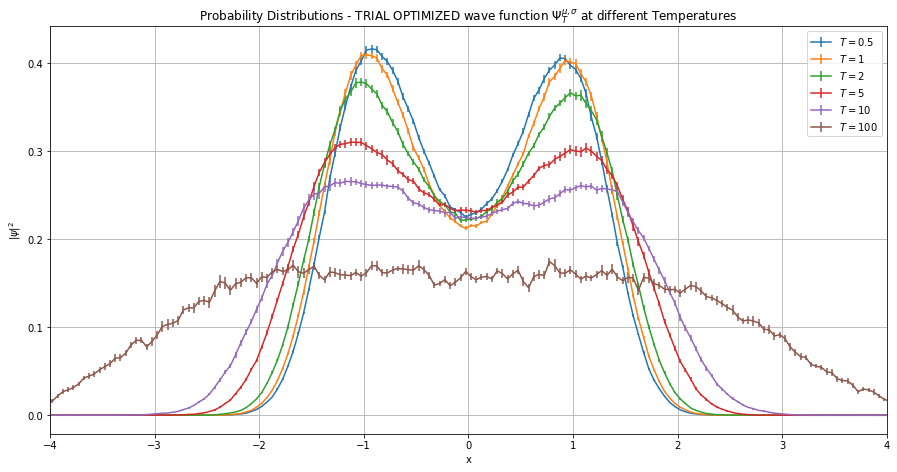

In [42]:
Tx_05,Tpsi_05,Terr_05=np.loadtxt("ES8.3/TRIAL_probability_T=0.5.dat", usecols=(0,1,2), unpack='true')
Tx_1,Tpsi_1,Terr_1=np.loadtxt("ES8.3/TRIAL_probability_T=1.dat", usecols=(0,1,2), unpack='true')
Tx_2,Tpsi_2,Terr_2=np.loadtxt("ES8.3/TRIAL_probability_T=2.dat", usecols=(0,1,2), unpack='true')
Tx_5,Tpsi_5,Terr_5=np.loadtxt("ES8.3/TRIAL_probability_T=5.dat", usecols=(0,1,2), unpack='true')
Tx_10,Tpsi_10,Terr_10=np.loadtxt("ES8.3/TRIAL_probability_T=10.dat", usecols=(0,1,2), unpack='true')
Tx_100,Tpsi_100,Terr_100=np.loadtxt("ES8.3/TRIAL_probability_T=100.dat", usecols=(0,1,2), unpack='true')
plt.figure(0,figsize=(15,7.5))

plt.errorbar(Tx_05,Tpsi_05,yerr=Terr_05,label='$T=0.5$')
plt.errorbar(Tx_1,Tpsi_1,yerr=Terr_1,label='$T=1$')
plt.errorbar(Tx_2,Tpsi_2,yerr=Terr_2,label='$T=2$')
plt.errorbar(Tx_5,Tpsi_5,yerr=Terr_5,label='$T=5$')
plt.errorbar(Tx_10,Tpsi_10,yerr=Terr_10,label='$T=10$')
plt.errorbar(Tx_100,Tpsi_100,yerr=Terr_100,label='$T=100$')

plt.legend(loc='upper right')
plt.xlabel("x")
plt.ylabel(r"$|\psi|^2$")
plt.title("Probability Distributions - TRIAL OPTIMIZED wave function $\Psi_T^{\mu,\sigma}$ at different Temperatures")
plt.xlim((-4,4))
plt.grid(True)
plt.show()

Vediamo dai grafici che, aumentando la temperatura, la curva della distribuzione di probabilità si distende, risultando in dei picchi sempre meno marcati: ciò è ragionevole, in quanto a temperature maggiori il sistema ha accesso a più stati eccitati, che vanno a contribuire in maniera più distribuita alla funzione d'onda globale.